In [76]:
# some basic imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from scipy.stats import ttest_ind
import json

# Two additional imports are required; math for the rounding function .ceil(), and scipt.stats for chi2 testing
import math
from scipy.stats import chi2_contingency

In [77]:
# data path
DATA = './data/'

# movie metadata loading
df_movies = pd.read_csv(DATA + 'movie.metadata.tsv', sep='\t', header=None)
df_movies.columns = ['wikipedia_id', 'freebase_id', 'title', 'release_date', 'revenue', 
                     'runtime', 'spoken_languages', 'countries', 'genres']

# charcaters metadata loading
df_characters = pd.read_csv(DATA + 'character.metadata.tsv', sep='\t', header=None)
df_characters.columns = ['wikipedia_id', 'freebase_id', 'release', 'character_name', 'actor_birth',
                     'actor_gender', 'actor_height', 'actor_ethnicity', 'actor_name', 
                     'age_at_release', 'freebase_map', 'freebase_character_id', 'freebase_actor_id']

# plot summaries
df_plots = pd.read_csv(DATA + 'plot_summaries.txt', sep='\t', header=None, names=['wikipedia_id', 'plot_summary'])

# TMDB dataset
df_tmdb = pd.read_csv(DATA + 'TMDB_movie_dataset_v11.csv')

In [78]:
# merging movie metadata and TMDB
df_movies_tmdb = pd.merge(df_movies, df_tmdb, on='title', how = 'inner')

In [79]:
# cleaning some movies columns 
def cleaning_fct(pattern):
    if pd.isna(pattern) or pattern == '{}':
        return None
    else:
        dict = json.loads(pattern)
        pattern = list(dict.values())
        return pattern

df_movies_tmdb['spoken_languages_x'] = df_movies_tmdb['spoken_languages_x'].apply(cleaning_fct)
df_movies_tmdb['countries'] = df_movies_tmdb['countries'].apply(cleaning_fct)
df_movies_tmdb['genres_x'] = df_movies_tmdb['genres_x'].apply(cleaning_fct)


In [80]:
# from the merged dataset, drop columns with more missing data and renaming the remaining columns
df_movies_tmdb = df_movies_tmdb.drop(['spoken_languages_y'], axis = 1).rename(columns={"spoken_languages_x": "spoken_languages"}) 
df_movies_tmdb = df_movies_tmdb.drop(['genres_y'], axis = 1).rename(columns={"genres_x": "genres"}) 
df_movies_tmdb = df_movies_tmdb.drop(['release_date_x'], axis = 1).rename(columns={"release_date_y": "release_date"}) 

In [81]:
# clean missing values in release_date and clean dates to keep the release year only
df_movies_tmdb = df_movies_tmdb.dropna(subset=['release_date'])
df_movies_tmdb['release_date'] = df_movies_tmdb['release_date'].str[:4].astype(int)

Basic Statistics

Number of Movies released in a specific year

In [82]:
release_years = df_movies_tmdb['release_date'].unique()
release_years.sort()

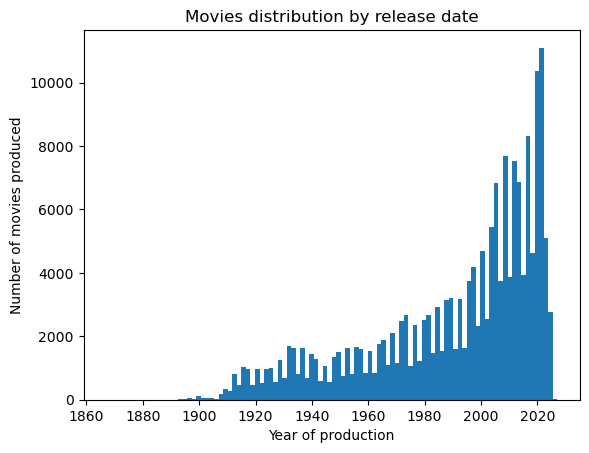

In [83]:
plt.figure()
plt.title('Movies distribution by release date')
plt.hist(df_movies_tmdb['release_date'], bins= 100)
plt.xlabel('Year of production')
plt.ylabel('Number of movies produced')
plt.show()


Number of movies by popularity

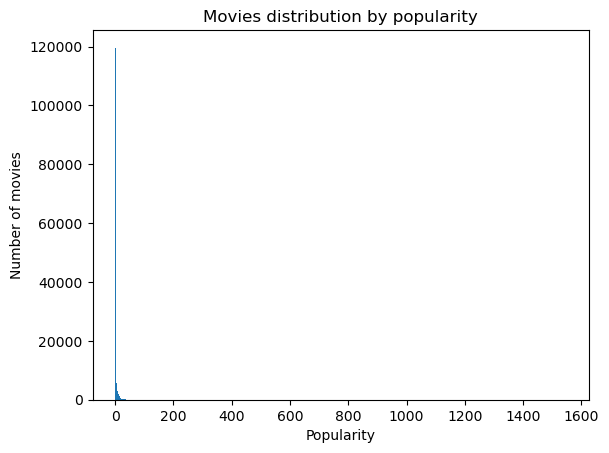

In [84]:
plt.figure()
plt.title('Movies distribution by popularity')
plt.hist(df_movies_tmdb['popularity'], bins= 1000)
plt.xlabel('Popularity')
plt.ylabel('Number of movies')
plt.show()

Grouping by genres

In [85]:
# from now on, if df == df_movies_tmdb, the datset taken into account is df_movies_tmdb
# grouping by genres (need a smaller dataframe to work with)
df_reduced = df_movies_tmdb[['title', 'genres', 'release_date']]

In [ ]:
# since there is more than 1 genre for each movie, we have to select all of them
df_grouped_genres = df_reduced.explode('genres')

# groupby genres
df_grouped_genres = df_grouped_genres.groupby('genres')

print("The number of different genres is:")
print(len(df_grouped_genres['genres'].unique()))
print('\n')

# print the groups
print('Print the groups')
for genre, group in df_grouped_genres:
    print(f"Genre: {genre}")
    print(group)

The number of different genres is:
359


Genre: Absurdism
                                             title     genres  release_date
2641                                  Brain Donors  Absurdism          1992
5025                                     Airplane!  Absurdism          1980
5938                           The Golf Specialist  Absurdism          1930
6925                              The Flower Thief  Absurdism          1962
8720               Monty Python and the Holy Grail  Absurdism          1975
...                                            ...        ...           ...
180218          Without a Paddle: Nature's Calling  Absurdism          2009
187443                      Take the Money and Run  Absurdism          1969
189000                   The L.A. Riot Spectacular  Absurdism          2005
191924  Trailer Park Boys: Countdown to Liquor Day  Absurdism          2009
197954                                 Top Secret!  Absurdism          1984

[120 rows x 3 columns]
Genre:

Select n most relevant genres, ordering them by recurrence

In [95]:
# counting how many movies share the same genre
counts = df_reduced.explode('genres')['genres'].value_counts()

print('Number of movies for each genre:')
print(counts)
print('\n')

# choosing the most relevant genres
n_relevant_genres = 20
relevant_genres = counts[:n_relevant_genres]

print('The relevant genres are:')
print(relevant_genres)

# making a list of names of the relevant genres
relevant_genres_names = relevant_genres.index.tolist()

Number of movies for each genre:
genres
Drama                 92790
Comedy                31162
Thriller              29519
Romance Film          27931
Black-and-white       21542
                      ...  
Romantic thriller         1
War effort                1
Breakdance                1
Conspiracy fiction        1
Homoeroticism             1
Name: count, Length: 359, dtype: int64


The relevant genres are:
genres
Drama               92790
Comedy              31162
Thriller            29519
Romance Film        27931
Black-and-white     21542
Action              19490
World cinema        18806
Crime Fiction       18647
Indie               18528
Short Film          15792
Horror              15191
Silent film         12907
Action/Adventure    11160
Adventure           10746
Romantic drama      10043
Mystery              9910
Musical              9166
Family Film          8626
Documentary          7961
Fantasy              7760
Name: count, dtype: int64


Number of movies produced every year, grouped by genres

In [ ]:
for genre in relevant_genres_names:
    plt.figure()
    plt.title('Movies distribution by release date')
    plt.hist(df_movies_tmdb['release_date'], bins= 100)
    plt.xlabel('Year of production')
    plt.ylabel('Number of movies produced')
    plt.show()


Vote average over date of production of the movie (keep in mind that the voting does not take place in the same year of production, but from then on)

Popularity over date of production of the movie (keep in mind that the popularity does not take place in the same year of production, but from then on) 

From the TMDb documentation: "Popularity is a fairly important metric here on TMDB. It helps us boost search results, adds an incredibly useful sort value for discover, and is also just kind of fun to see items chart up and down. You can think of popularity as being a "lifetime" popularity score that is impacted by the attributes below. It's calculated quite differently than trending."